<a href="https://colab.research.google.com/github/SunbirdAI/lamwo-electrification-project/blob/main/notebooks/predicting_minigrid_villages/train_minigrid_village_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train minigrid village predictor

Train a binary classifier that predicts whether a particular village is best suited for a minigrid or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

## 1. Data Loading and Preprocessing

In [2]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    df['electrification_strategy'] = df['electrification_strategy'].apply(
        lambda x: 1 if x in ['Candidate minigrid', 'Existing minigrid'] else 0
    )

    exclude_features = ['village_id', 'candidate_minigrids', 'existing_minigrids', 'protected_area_name']
    X = df.drop(columns=exclude_features + ['electrification_strategy'])
    y = df['electrification_strategy']

    X['contains_protected_area'] = X['contains_protected_area'].astype(int)
    X = X.fillna(0)

    return X, y

## 2. Model Training with Grid Search and Threshold Evaluation

In [3]:
def train_and_evaluate_models(X, y, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Parameter grids
    log_reg_param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }

    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', None]
    }

    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    rf_clf = RandomForestClassifier(random_state=42)

    log_reg_grid = GridSearchCV(log_reg, log_reg_param_grid, cv=5, scoring='f1', n_jobs=-1)
    rf_grid = GridSearchCV(rf_clf, rf_param_grid, cv=5, scoring='f1', n_jobs=-1)

    log_reg_grid.fit(X_train_scaled, y_train)
    rf_grid.fit(X_train_scaled, y_train)

    best_log_reg = log_reg_grid.best_estimator_
    best_rf = rf_grid.best_estimator_

    models = {
        'Logistic Regression': best_log_reg,
        'Random Forest': best_rf
    }

    results = {}

    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')

        model.fit(X_train_scaled, y_train)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]

        # Evaluate different thresholds
        threshold_results = {}
        for threshold in thresholds:
            y_pred = (y_prob >= threshold).astype(int)
            threshold_results[threshold] = {
                'y_pred': y_pred,
                'classification_report': classification_report(y_test, y_pred,
                                                             target_names=['Not Minigrid', 'Minigrid'],
                                                             output_dict=True)
            }

        results[name] = {
            'model': model,
            'cv_scores': cv_scores,
            'y_prob': y_prob,
            'y_test': y_test,
            'best_params': (log_reg_grid.best_params_ if name == 'Logistic Regression' else rf_grid.best_params_),
            'threshold_results': threshold_results
        }

        print(f"\n{name}:")
        print(f"Best Parameters: {results[name]['best_params']}")
        print(f"Cross-validation F1 scores: {cv_scores}")
        print(f"Mean CV F1: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print("\nPerformance at Different Thresholds:")
        for threshold, tr in threshold_results.items():
            print(f"\nThreshold = {threshold}:")
            print(classification_report(y_test, tr['y_pred'], target_names=['Not Minigrid', 'Minigrid']))

    return results, X_train_scaled, X_test_scaled, y_train, y_test, scaler

## 3. Visualization

In [4]:
def plot_results(results, X, y):
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))

    for idx, (name, result) in enumerate(results.items()):
        # Confusion Matrix (using default threshold of 0.5)
        y_pred_default = result['threshold_results'][0.5]['y_pred']
        cm = confusion_matrix(result['y_test'], y_pred_default)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx, 0],
                   xticklabels=['Not Minigrid', 'Minigrid'],
                   yticklabels=['Not Minigrid', 'Minigrid'])
        axes[idx, 0].set_title(f'Confusion Matrix - {name} (Threshold=0.5)')

        # Precision-Recall Curve
        precision, recall, thresholds = precision_recall_curve(result['y_test'], result['y_prob'])
        axes[idx, 1].plot(recall, precision)
        axes[idx, 1].set_title(f'Precision-Recall Curve - {name}')
        axes[idx, 1].set_xlabel('Recall')
        axes[idx, 1].set_ylabel('Precision')
        axes[idx, 1].grid(True)

    # Feature Importance for Random Forest
    rf_result = results['Random Forest']
    importances = rf_result['model'].feature_importances_
    indices = np.argsort(importances)[::-1]

    axes[2, 0].bar(range(X.shape[1]), importances[indices])
    axes[2, 0].set_title('Random Forest Feature Importance')
    axes[2, 0].set_xticks(range(X.shape[1]))
    axes[2, 0].set_xticklabels(X.columns[indices], rotation=90)
    axes[2, 0].set_ylabel('Importance')

    axes[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

## 4. Feature Importance Analysis

In [5]:
def analyze_feature_importance(results, X):
    for name, result in results.items():
        if name == 'Random Forest':
            print(f"\nFeature Importance for {name}:")
            importances = result['model'].feature_importances_
            feature_imp = pd.DataFrame({
                'feature': X.columns,
                'importance': importances
            }).sort_values('importance', ascending=False)
            print(feature_imp)

        elif name == 'Logistic Regression':
            print(f"\nFeature Coefficients for {name}:")
            coefficients = pd.DataFrame({
                'feature': X.columns,
                'coefficient': np.abs(result['model'].coef_[0])
            }).sort_values('coefficient', ascending=False)
            print(coefficients)



## Train LR and RF models

Load and preprocess data

In [6]:
file_path = 'village_data.csv'
X, y = load_and_preprocess_data(file_path)

In [7]:
X.head()

,facilities,grid_extension,existing_grid,mean_ndvi,mean_wind_speed,mean_pvout_solar_radiation,building_count,permanent_building_count,educational_facilities,health_facilities,social_facilities,services,primary_roads,secondary_roads,tertiary_roads,unclassified_roads,percentage_crop_land,percentage_built_area,contains_protected_area
0,0,0,0,0.000000,0.000000,0.000000,7,0,0,0,0,0,0,0,0,0,20.356667,1.140000,0
1,1,0,0,0.000000,0.000000,1563.144571,17,3,0,1,0,0,0,0,0,1,3.387500,0.026667,1
2,0,0,0,0.000000,0.000000,1561.565267,99,5,0,0,0,0,0,0,0,0,16.712500,3.160000,1
3,0,0,0,0.300514,0.895073,1587.815039,101,4,0,0,0,0,0,0,0,0,24.385000,2.506667,1
4,0,0,0,0.000000,0.000000,1618.240479,0,0,0,0,0,0,0,0,0,0,20.292500,0.015000,1


In [8]:
y.head()

,electrification_strategy
0,0
1,0
2,0
3,0
4,0


Train and evaluate models

In [9]:
results, X_train_scaled, X_test_scaled, y_train, y_test, scaler = train_and_evaluate_models(X, y)



Logistic Regression:
Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Cross-validation F1 scores: [0.33333333 0.47619048 0.42857143 0.47058824 0.30769231]
Mean CV F1: 0.403 (+/- 0.140)

Performance at Different Thresholds:

Threshold = 0.3:
              precision    recall  f1-score   support

Not Minigrid       0.90      0.87      0.88        70
    Minigrid       0.40      0.46      0.43        13

    accuracy                           0.81        83
   macro avg       0.65      0.67      0.66        83
weighted avg       0.82      0.81      0.81        83


Threshold = 0.4:
              precision    recall  f1-score   support

Not Minigrid       0.90      0.90      0.90        70
    Minigrid       0.46      0.46      0.46        13

    accuracy                           0.83        83
   macro avg       0.68      0.68      0.68        83
weighted avg       0.83      0.83      0.83        83


Threshold = 0.5:
              precision    recall  f1-score   supp

Plot results

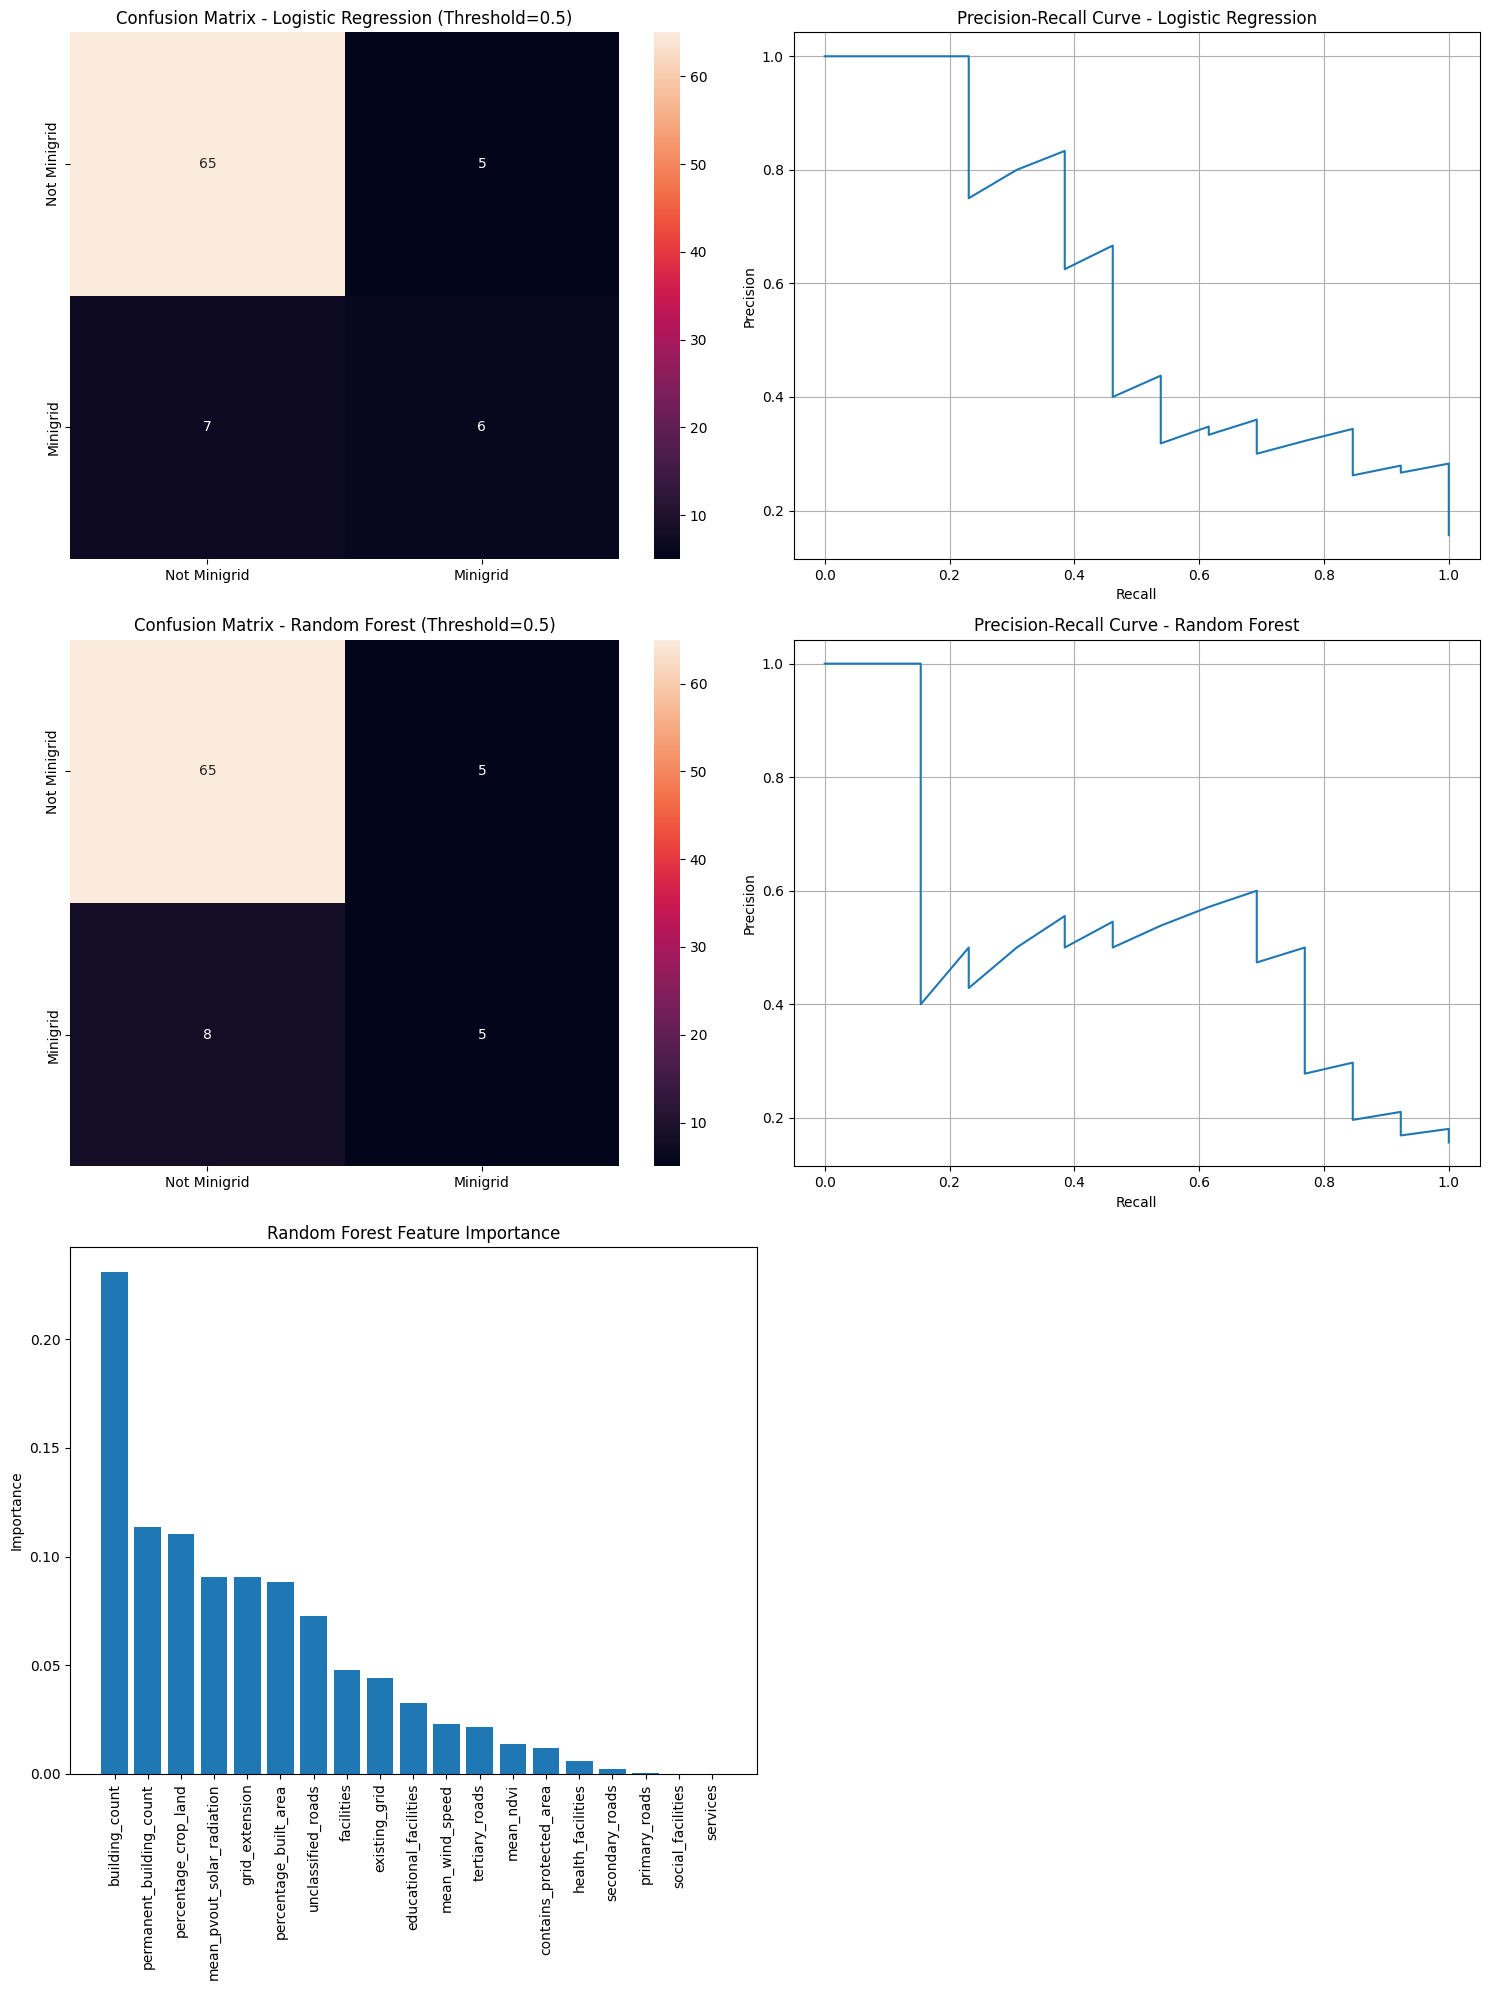

In [10]:
plot_results(results, X, y)

Analyze feature importance.

In [11]:
analyze_feature_importance(results, X)


Feature Coefficients for Logistic Regression:
                       feature  coefficient
4              mean_wind_speed     4.583390
3                    mean_ndvi     4.539632
2                existing_grid     2.187637
1               grid_extension     2.151664
7     permanent_building_count     1.100200
6               building_count     1.067495
0                   facilities     0.741884
17       percentage_built_area     0.504381
9            health_facilities     0.467005
15          unclassified_roads     0.399662
18     contains_protected_area     0.322218
5   mean_pvout_solar_radiation     0.297924
12               primary_roads     0.179069
14              tertiary_roads     0.139006
16        percentage_crop_land     0.107578
13             secondary_roads     0.098365
8       educational_facilities     0.096025
10           social_facilities     0.000000
11                    services     0.000000

Feature Importance for Random Forest:
                       feature  im

Save models

In [12]:
!mkdir models

In [13]:
save_path = 'models/'
pickle.dump(results['Logistic Regression']['model'], open(f'{save_path}log_reg_model.pkl', 'wb'))
pickle.dump(results['Random Forest']['model'], open(f'{save_path}rf_model.pkl', 'wb'))
pickle.dump(scaler, open(f'{save_path}scaler.pkl', 'wb'))
with open(f'{save_path}feature_names.txt', 'w') as f:
    f.write(','.join(X.columns))

In [14]:
!zip -r minigrid_village_predictor_models.zip models

  adding: models/ (stored 0%)
  adding: models/rf_model.pkl (deflated 71%)
  adding: models/feature_names.txt (deflated 49%)
  adding: models/log_reg_model.pkl (deflated 26%)
  adding: models/scaler.pkl (deflated 27%)
